In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import WeightedRandomSampler
from src.data.syntetic_data import BLOND, Generator, Discriminator
from src.features.features import ACPower, COT, AOT, DCS, MFCC, MelSpectrogram, Spectrogram

%load_ext autoreload
%autoreload 2

C:\Users\jonas\miniconda3\envs\py3.8-gpu\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [2]:
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

True


In [3]:
batch_size = 128
class_dict = {
    #'Battery Charger': 0,
    'Daylight': 1,
    #'Dev Board': 2,
    #'Laptop': 3,
    #'Monitor': 4,
    #'PC': 5,
    #'Printer': 6,
    #'Projector': 7,
    #'Screen Motor': 8,
    #'USB Charger': 9
    #'Kettle': 10
}

dataset = BLOND('../data/', class_dict)
sampler = WeightedRandomSampler(dataset.labels['Weight'].values, len(dataset), replacement=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)
num_classes = len(dataset.class_dict.keys())
print(len(dataset))

128


In [4]:
"""
max = 0
min = 0
for i, (real, _, _) in enumerate(dataloader, 0):
    tmp_max = torch.max(real)
    tmp_min = torch.min(real)
    if max < tmp_max:
        max = tmp_max
    if min > tmp_min:
        min = tmp_min
print(f'Max value: {max}')
print(f'Min value: {min}')

def normalize(x, max=max, min=min):

    return 2 * (x - min)/(max - min) - 1

def denormalize(x, max=max, min=min):

    return 0.5 * (x*max - x*min + max + min)
"""

"\nmax = 0\nmin = 0\nfor i, (real, _, _) in enumerate(dataloader, 0):\n    tmp_max = torch.max(real)\n    tmp_min = torch.min(real)\n    if max < tmp_max:\n        max = tmp_max\n    if min > tmp_min:\n        min = tmp_min\nprint(f'Max value: {max}')\nprint(f'Min value: {min}')\n\ndef normalize(x, max=max, min=min):\n\n    return 2 * (x - min)/(max - min) - 1\n\ndef denormalize(x, max=max, min=min):\n\n    return 0.5 * (x*max - x*min + max + min)\n"

In [5]:
G = Generator().to(device)
D = Discriminator().to(device)

In [6]:
lr = 1e-2
std = 0.01

In [7]:
G_solver = optim.RMSprop(G.parameters(), lr=lr)
D_solver = optim.RMSprop(D.parameters(), lr=lr)
G_scheduler = StepLR(G_solver, 300, 0.1)
D_scheduler = StepLR(D_solver, 300, 0.1)
mse_loss = nn.MSELoss()

"""
https://github.com/wiseodd/generative-models/blob/master/GAN/wasserstein_gan/wgan_pytorch.py
"""
for it in range(201):
    for _ in range(5):
        # Sample data
        x, _, _ = next(iter(dataloader))
        noise = x.data.new(x.size()).normal_(0, std)
        z = x + noise
        z = z.to(device)
        z = z.unsqueeze(1)
        x = x.to(device)
        x = x.unsqueeze(1)

        # Dicriminator forward-loss-backward-update
        G_sample = G(z)
        D_real = D(x)
        D_fake = D(G_sample)

        D_loss = -(torch.mean(D_real) - torch.mean(D_fake))

        D_loss.backward()
        D_solver.step()

        # Weight clipping
        for p in D.parameters():
            p.data.clamp_(-0.01, 0.01)

        G.zero_grad()
        D.zero_grad()

    # Generator forward-loss-backward-update
    x, _, _ = next(iter(dataloader))
    noise = x.data.new(x.size()).normal_(0, std)
    z = x + noise
    z = z.to(device)
    z = z.unsqueeze(1)
    x = x.to(device)
    x = x.unsqueeze(1)

    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = -torch.mean(D_fake)
    G_mse = mse_loss(G_sample, x)
    G_loss = G_loss + G_mse

    G_loss.backward()
    G_solver.step()

    G.zero_grad()
    D.zero_grad()

    G_scheduler.step()
    D_scheduler.step()

    if it % 10 == 0:
        print(f'Iteration{it}; D_loss: {D_loss}; G_loss: {G_loss}')


KeyboardInterrupt: 

In [30]:
#torch.save(G.state_dict(), f"generator_model_{list(class_dict.keys())[0]}.pth")
G.load_state_dict(torch.load(f"generator/generator_model_{list(class_dict.keys())[0]}.pth"))

<All keys matched successfully>

In [31]:
x, v, c = next(iter(dataloader))
x = x.unsqueeze(1)
noise = x.data.new(x.size()).normal_(0, std)
Z = (x + noise).to(device)
x = x.to(device)

generated_X = G(Z).detach().cpu().squeeze()

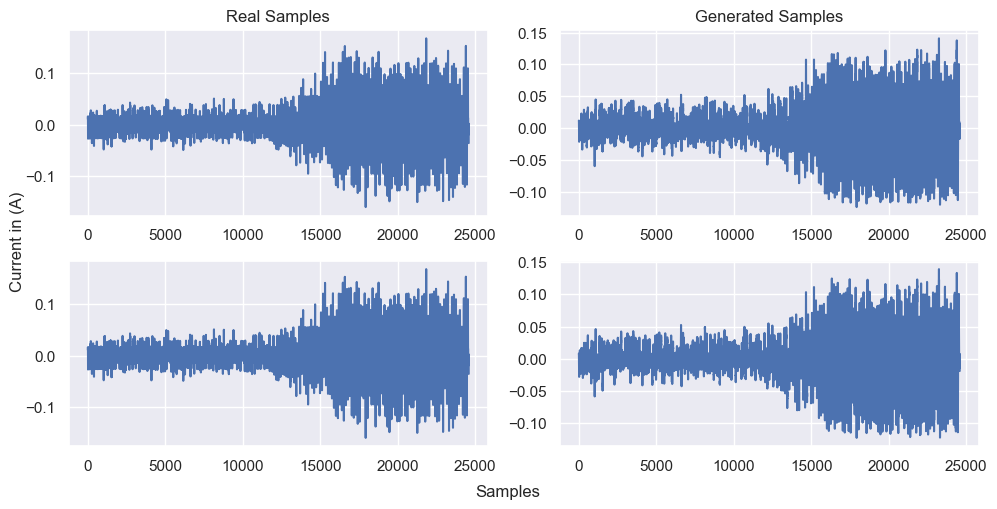

In [42]:
x = x.cpu().squeeze()

import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

axes[0, 1].set_title('Generated Samples')
axes[0, 0].set_title('Real Samples')
for i in range(2):
    axes[i, 0].plot(x[i])
    axes[i, 1].plot(generated_X[i])

#fig.text(0.5, -0.01, 'Measurments', ha='center', va='center')
fig.text(0.01, 0.5, 'Current in (A)', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0, 'Samples', ha='center', va='center')
plt.tight_layout()
plt.savefig('figures/comparison_gen_real.svg', bbox_extra_artists=(fig,), bbox_inches='tight')
plt.show()

In [33]:
x = x.cpu().squeeze()
x = x[:, 511:x.size(1)-511]
v = v[:, 511:v.size(1)-511]
generated_X = generated_X[:, 511:generated_X.size(1)-511]

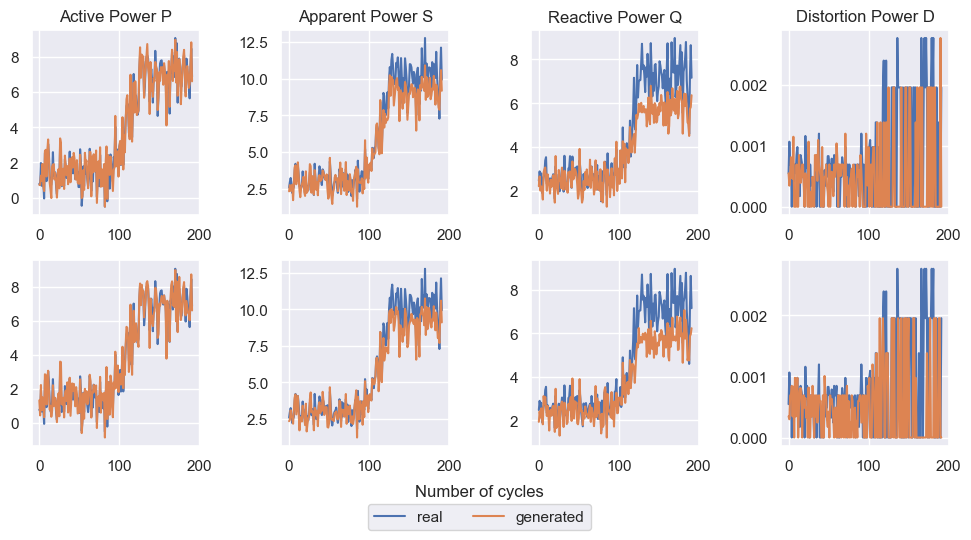

In [34]:
ac = ACPower(measurement_frequency=6400)

fig, axes = plt.subplots(2, 4, figsize=(10, 5))

axes[0, 0].set_title('Active Power P')
axes[0, 1].set_title('Apparent Power S')
axes[0, 2].set_title('Reactive Power Q')
axes[0, 3].set_title('Distortion Power D')

for i in range(0, 2):
    _, _, features, _ = ac((x[i], v[i], None ,c[i]))
    _, _, gen_features, _ = ac((generated_X[i], v[i], None ,c[i]))

    axes[i, 0].plot(features[0])
    axes[i, 0].plot(gen_features[0])

    axes[i, 1].plot(features[1])
    axes[i, 1].plot(gen_features[1])

    axes[i, 2].plot(features[2])
    axes[i, 2].plot(gen_features[2])

    axes[i, 3].plot(features[3])
    axes[i, 3].plot(gen_features[3])

fig.text(0.5, 0, 'Number of cycles', ha='center', va='center')
lgd = fig.legend(['real', 'generated'], loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=5)
plt.tight_layout()
plt.savefig('figures/ac_generated.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

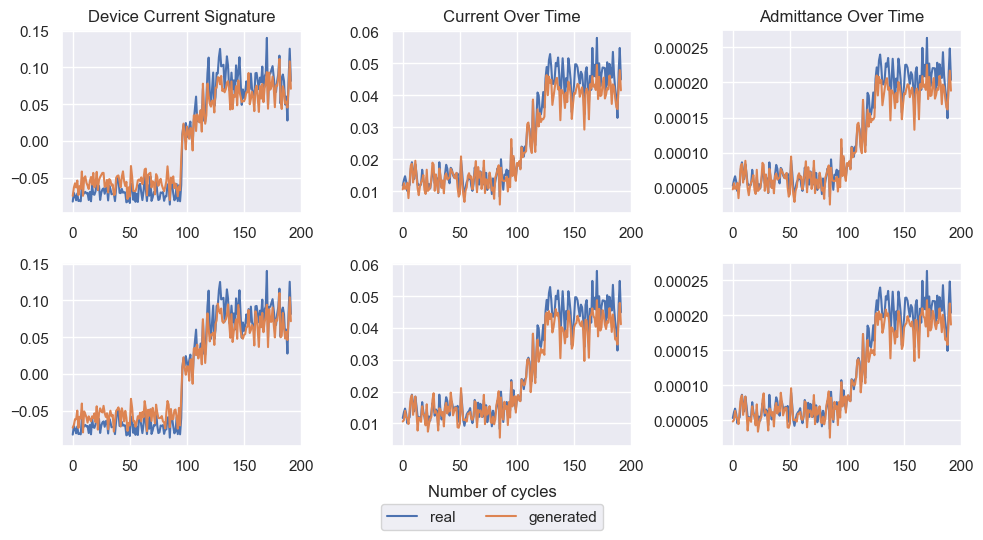

In [37]:
x = x.cpu().squeeze()
dcs = DCS(measurement_frequency=6400)
cot = COT(measurement_frequency=6400)
aot = AOT(measurement_frequency=6400)

fig, axes = plt.subplots(2, 3, figsize=(10, 5))

axes[0, 0].set_title('Device Current Signature')
axes[0, 1].set_title('Current Over Time')
axes[0, 2].set_title('Admittance Over Time')

for i in range(0, 2):
    _, _, features, _ = dcs((x[i], v[i], None ,c[i]))
    _, _, gen_features, _ = dcs((generated_X[i], v[i], None ,c[i]))
    axes[i, 0].plot(features[0])
    axes[i, 0].plot(gen_features[0])

    _, _, features, _ = cot((x[i], v[i], None ,c[i]))
    _, _, gen_features, _ = cot((generated_X[i], v[i], None ,c[i]))
    axes[i, 1].plot(features[0])
    axes[i, 1].plot(gen_features[0])

    _, _, features, _ = aot((x[i], v[i], None ,c[i]))
    _, _, gen_features, _ = aot((generated_X[i], v[i], None ,c[i]))
    axes[i, 2].plot(features[0])
    axes[i, 2].plot(gen_features[0])

fig.text(0.5, 0, 'Number of cycles', ha='center', va='center')
lgd = fig.legend(['real', 'generated'], loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=5)
plt.tight_layout()
plt.savefig('figures/other_generated.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

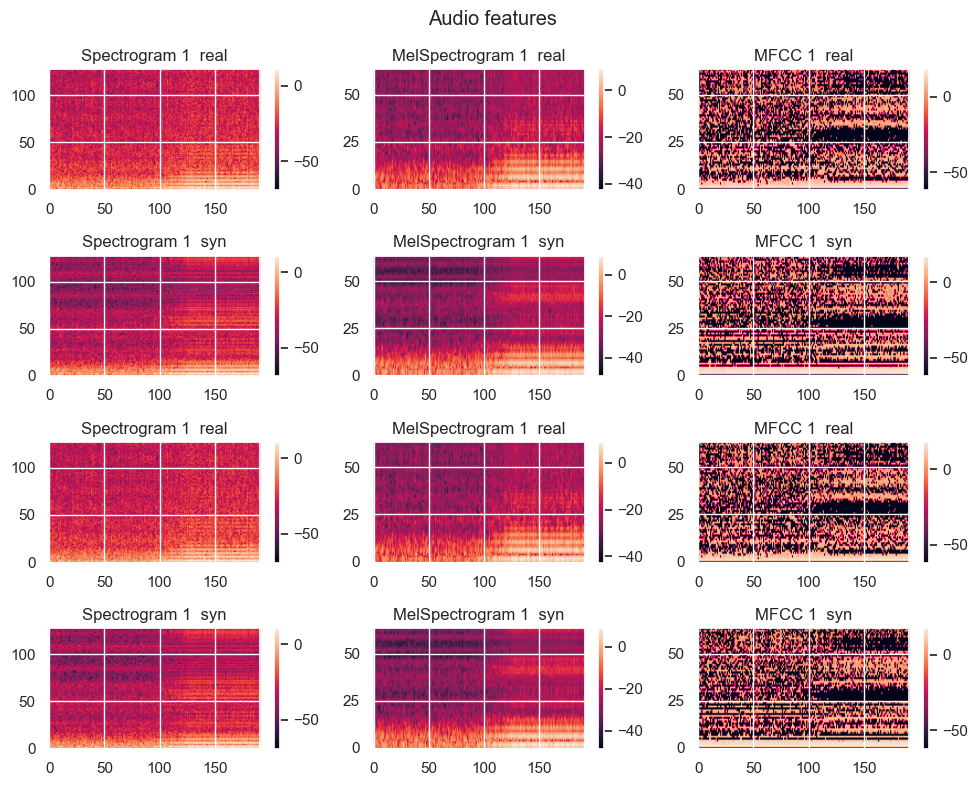

In [36]:
import librosa
spec = Spectrogram(measurement_frequency=6400)
mel_spec = MelSpectrogram(measurement_frequency=6400)
mfcc = MFCC(measurement_frequency=6400)

plt.figure(figsize=(10, 8))
plt.suptitle(f'Audio features')

j = 0
k = 0
for i in range(0, 4):

    if i % 2 == 0:
        sample = x[k], v[k], c[k]
        sub = ' real'
        k += 1
    else:
        sample = generated_X[j], v[j], c[j]
        sub = ' syn'
        j += 1

    _, _, features, class_nr = spec((sample[0], sample[1], None, sample[2]))
    plt.subplot(4, 3, i*3+1)
    plt.imshow(librosa.power_to_db(features), origin='lower', aspect='auto')
    plt.colorbar()
    plt.title(f'Spectrogram {sample[2]} {sub}')

    _, _, features, class_nr = mel_spec((sample[0], sample[1], None, sample[2]))
    plt.subplot(4, 3, i*3+2)
    plt.imshow(librosa.power_to_db(features), origin='lower', aspect='auto')
    plt.colorbar()
    plt.title(f'MelSpectrogram {sample[2]} {sub}')

    _, _, features, class_nr = mfcc((sample[0], sample[1], None, sample[2]))
    plt.subplot(4, 3, i*3+3)
    plt.imshow(librosa.power_to_db(features), origin='lower', aspect='auto')
    plt.colorbar()
    plt.title(f'MFCC {sample[2]} {sub}')

plt.tight_layout()
plt.show()